# Laboratorio 5

## Integrantes

### Sergio Orellana - 221122

### Andre Marroquin - 22266

### Rodrigo Mansilla - 22611

# Link del repositorio

https://github.com/mar22266/LABORATORIOS-IA.git

# Link del video

https://youtu.be/Mm09CF76MlI




# Task 1 - Graph-Search


## Task 1.1 - Discretización de la imagen


In [ ]:
from PIL import Image
import numpy as np

# Retorna True si el píxel se encuentra dentro de la tolerancia
def esColor(pixel, objetivo, tolerancia=10):
    return all(abs(pixel[i] - objetivo[i]) <= tolerancia for i in range(3))

# Convierte la imagen en una matriz discreta
def discretizarImagen(rutaArchivo, tamCelda=1):
    imagen = Image.open(rutaArchivo).convert('RGB')
    ancho, alto = imagen.size
    matriz = np.zeros((alto, ancho), dtype=np.int32)
    inicio = None
    metas = []
    for i in range(alto):
        for j in range(ancho):
            pixel = imagen.getpixel((j, i))
            if esColor(pixel, (0, 0, 0)):  # Muro
                matriz[i, j] = 0
            elif esColor(pixel, (255, 255, 255)):  # Camino libre
                matriz[i, j] = 1
            elif esColor(pixel, (0, 255, 0)):  # Meta
                matriz[i, j] = 2
                metas.append((i, j))
            elif esColor(pixel, (255, 0, 0)):  # Inicio
                matriz[i, j] = 3
                inicio = (i, j)
            else:
                # Para cualquier otro color se asume camino libre
                matriz[i, j] = 1
    if inicio is None:
        raise ValueError(f"No se encontro el punto de inicio rojo en la imagen: {rutaArchivo}")
    if not metas:
        raise ValueError(f"No se encontro ninguna meta verde en la imagen: {rutaArchivo}")
    return matriz, inicio, metas

## Task 1.2 - Framework de Problemas


In [61]:
from abc import ABC, abstractmethod

# Clase abstracta para definir un problema de búsqueda
class Problema(ABC):
    @abstractmethod
    def estadoInicial(self):
        pass

    @abstractmethod
    def acciones(self, estado):
        pass

    @abstractmethod
    def resultado(self, estado, accion):
        pass

    @abstractmethod
    def pruebaObjetivo(self, estado):
        pass

    @abstractmethod
    def costoPaso(self, estado, accion, estadoSiguiente):
        pass

# Inicializa el problema del laberinto
class ProblemaLaberinto(Problema):
    def __init__(self, matriz, inicio, metas):
        self.matriz = matriz
        self.inicio = inicio
        self.metas = metas
        self.filas, self.columnas = matriz.shape

    def estadoInicial(self):
        return self.inicio

    def pruebaObjetivo(self, estado):
        return estado in self.metas

    # Retorna las acciones posibles en un estado dado
    def acciones(self, estado):
        movimientosPosibles = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        accionesValidas = []
        for movimiento in movimientosPosibles:
            nuevoEstado = (estado[0] + movimiento[0], estado[1] + movimiento[1])
            # Verificar limites de la matriz
            if 0 <= nuevoEstado[0] < self.filas and 0 <= nuevoEstado[1] < self.columnas:
                # Se permite avanzar si la celda no es muro (valor 0)
                if self.matriz[nuevoEstado[0], nuevoEstado[1]] != 0:
                    accionesValidas.append(movimiento)
        return accionesValidas

    # Retorna el estado resultante de aplicar una accion a un estado dado
    def resultado(self, estado, accion):
        return (estado[0] + accion[0], estado[1] + accion[1])
    
    # Retorna el costo de step que es 1
    def costoPaso(self, estado, accion, estadoSiguiente):
        return 1

## Task 1.3 - Graph-Search


In [62]:
from collections import deque
import heapq

# Implementacion de BFS devuelve el camino desde el inicio hasta una meta
def busquedaAnchura(problema):
    inicio = problema.estadoInicial()
    frontera = deque([[inicio]])
    explorados = set()
    
    while frontera:
        camino = frontera.popleft()
        estado = camino[-1]
        if problema.pruebaObjetivo(estado):
            return camino
        explorados.add(estado)
        for accion in problema.acciones(estado):
            hijo = problema.resultado(estado, accion)
            if hijo not in explorados and hijo not in (p[-1] for p in frontera):
                nuevoCamino = list(camino)
                nuevoCamino.append(hijo)
                frontera.append(nuevoCamino)
    return None

# Implementacion de DFS devuelve el camino desde el inicio hasta una meta
def busquedaProfundidad(problema):
    inicio = problema.estadoInicial()
    frontera = [[inicio]]
    explorados = set()
    
    while frontera:
        camino = frontera.pop()
        estado = camino[-1]
        if problema.pruebaObjetivo(estado):
            return camino
        explorados.add(estado)
        for accion in problema.acciones(estado):
            hijo = problema.resultado(estado, accion)
            if hijo not in explorados and hijo not in (p[-1] for p in frontera):
                nuevoCamino = list(camino)
                nuevoCamino.append(hijo)
                frontera.append(nuevoCamino)
    return None

# Implementacion de A* devuelve el camino desde el inicio hasta una meta tiene en cuenta la heuristica
def busquedaAEstrella(problema, heuristica):
    inicio = problema.estadoInicial()
    frontera = []
    heapq.heappush(frontera, (heuristica(inicio, problema), 0, [inicio]))
    explorados = {}
    
    while frontera:
        costoEstimado, costoHastaAhora, camino = heapq.heappop(frontera)
        estado = camino[-1]
        if problema.pruebaObjetivo(estado):
            return camino
        if estado in explorados and explorados[estado] <= costoHastaAhora:
            continue
        explorados[estado] = costoHastaAhora
        for accion in problema.acciones(estado):
            hijo = problema.resultado(estado, accion)
            nuevoCosto = costoHastaAhora + problema.costoPaso(estado, accion, hijo)
            nuevoCostoEstimado = nuevoCosto + heuristica(hijo, problema)
            nuevoCamino = list(camino)
            nuevoCamino.append(hijo)
            heapq.heappush(frontera, (nuevoCostoEstimado, nuevoCosto, nuevoCamino))
    return None


# Heuristica Manhattan, suma de las diferencias absolutas en filas y columnas desde el estado actual hasta la meta mas cercana.
def heuristicaManhattan(estado, problema):
    distanciaMinima = float('inf')
    for meta in problema.metas:
        distancia = abs(estado[0] - meta[0]) + abs(estado[1] - meta[1])
        if distancia < distanciaMinima:
            distanciaMinima = distancia
    return distanciaMinima

# Heuristica Euclidiana, distancia en linea recta desde el estado actual hasta la meta mas cercana.
def heuristicaEuclidiana(estado, problema):
    distanciaMinima = float('inf')
    for meta in problema.metas:
        distancia = ((estado[0] - meta[0])**2 + (estado[1] - meta[1])**2)**0.5
        if distancia < distanciaMinima:
            distanciaMinima = distancia
    return distanciaMinima

### Justifique la elección de estas heurísticas

Usamos la heurística de Manhattan cuando solo podemos movernos en línea recta. Esta mide la cantidad mínima de pasos necesarios en una cuadrícula y siempre da estimaciones correctas, por lo que es ideal para laberintos donde no se permiten movimientos en diagonal.

Por otro lado, la heurística Euclidiana es más útil si podemos movernos en cualquier dirección, incluyendo diagonales. Calcula la distancia directa entre dos puntos, lo que da una estimación más precisa del recorrido en un espacio continuo.

En este caso, se usaron ambas heurísticas para comparar su desempeño en diferentes escenarios. La heurística de Manhattan es ideal para laberintos con movimientos ortogonales, mientras que la Euclidiana es útil si se permiten diagonales.

## Task 1.4 - Construcción de Salida


## Se muestran los caminos encontrados para los 3 diferentes laberintos dejando su proceso 

In [63]:
import matplotlib.pyplot as plt

# Visualiza el laberinto con la solucion
# Los colores se asignan de la siguiente forma:
# - 0: Muro
# - 1: Camino libre
# - 2: Meta
# - 3: Inicio
def graficarSolucionLaberinto(matriz, camino, titulo="Solucion del Laberinto"):
    plt.figure(figsize=(8,8))
    filas, columnas = matriz.shape
    # Crear una imagen RGB a partir de la matriz discreta
    imagenRGB = np.zeros((filas, columnas, 3), dtype=np.uint8)
    for i in range(filas):
        for j in range(columnas):
            if matriz[i, j] == 0:
                imagenRGB[i, j] = [0, 0, 0]         
            elif matriz[i, j] == 1:
                imagenRGB[i, j] = [255, 255, 255]   
            elif matriz[i, j] == 2:
                imagenRGB[i, j] = [0, 255, 0]       
            elif matriz[i, j] == 3:
                imagenRGB[i, j] = [255, 0, 0]    
    plt.imshow(imagenRGB)
    
    if camino is not None:
        # Extraer coordenadas para la visualizacion
        coordenadasX = [p[1] for p in camino]
        coordenadasY = [p[0] for p in camino]
        plt.plot(coordenadasX, coordenadasY, marker='o', color='blue', linewidth=0.5, markersize=0.5)
    plt.title(titulo)
    plt.axis('off')
    plt.show()


--------------------------------------------------
Procesando imagen: Test.bmp
Punto de inicio: (471, 450)
Puntos meta: [(69, 481), (69, 482), (69, 483), (69, 484), (69, 485), (70, 480), (70, 481), (70, 482), (70, 483), (70, 484), (70, 485), (70, 486), (70, 487), (70, 488), (71, 478), (71, 479), (71, 480), (71, 481), (71, 482), (71, 483), (71, 484), (71, 485), (71, 486), (71, 487), (71, 488), (71, 489), (71, 490), (72, 477), (72, 478), (72, 479), (72, 484), (72, 485), (72, 486), (72, 487), (72, 488), (72, 489), (72, 490), (73, 477), (73, 478), (73, 479), (73, 481), (73, 482), (73, 483), (73, 484), (73, 485), (73, 486), (73, 487), (73, 490), (73, 491), (74, 476), (74, 477), (74, 478), (74, 479), (74, 481), (74, 482), (74, 483), (74, 484), (74, 485), (74, 486), (74, 487), (74, 488), (74, 489), (74, 491), (75, 476), (75, 477), (75, 478), (75, 479), (75, 480), (75, 481), (75, 482), (75, 483), (75, 484), (75, 485), (75, 486), (75, 487), (75, 488), (75, 489), (75, 490), (75, 492), (76, 475)

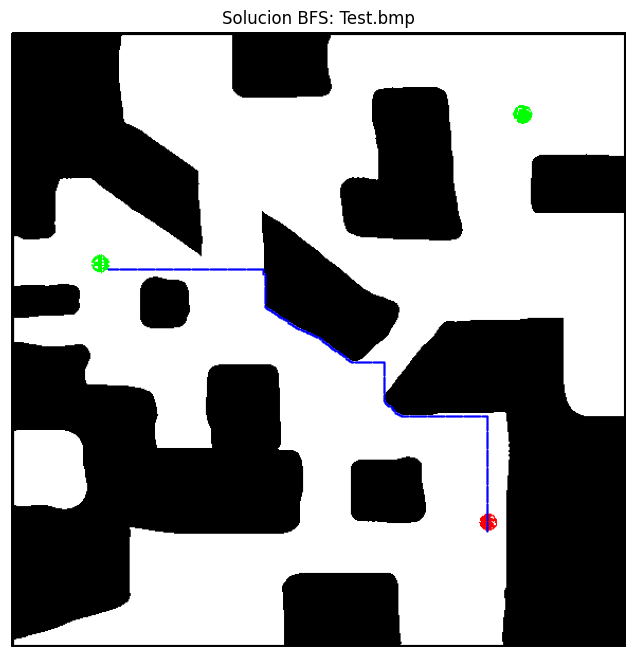


Resolviendo con Depth First Search DFS...
Camino (DFS):
Paso 0: (471, 450)
Paso 1: (471, 451)
Paso 2: (471, 452)
Paso 3: (471, 453)
Paso 4: (471, 454)
Paso 5: (471, 455)
Paso 6: (471, 456)
Paso 7: (471, 457)
Paso 8: (471, 458)
Paso 9: (471, 459)
Paso 10: (471, 460)
Paso 11: (471, 461)
Paso 12: (471, 462)
Paso 13: (471, 463)
Paso 14: (471, 464)
Paso 15: (471, 465)
Paso 16: (471, 466)
Paso 17: (471, 467)
Paso 18: (471, 468)
Paso 19: (472, 468)
Paso 20: (473, 468)
Paso 21: (473, 467)
Paso 22: (473, 466)
Paso 23: (473, 465)
Paso 24: (473, 464)
Paso 25: (473, 463)
Paso 26: (473, 462)
Paso 27: (473, 461)
Paso 28: (473, 460)
Paso 29: (473, 459)
Paso 30: (473, 458)
Paso 31: (473, 457)
Paso 32: (473, 456)
Paso 33: (473, 455)
Paso 34: (473, 454)
Paso 35: (473, 453)
Paso 36: (473, 452)
Paso 37: (473, 451)
Paso 38: (473, 450)
Paso 39: (473, 449)
Paso 40: (473, 448)
Paso 41: (473, 447)
Paso 42: (473, 446)
Paso 43: (473, 445)
Paso 44: (473, 444)
Paso 45: (473, 443)
Paso 46: (473, 442)
Paso 47: (473

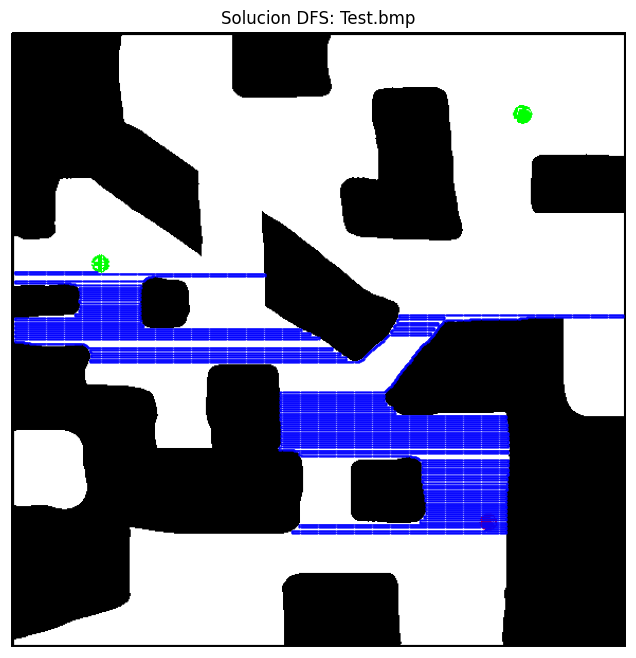


Resolviendo con A* Heuristica Manhattan...
Camino (A* Manhattan):
Paso 0: (471, 450)
Paso 1: (470, 450)
Paso 2: (469, 450)
Paso 3: (468, 450)
Paso 4: (467, 450)
Paso 5: (466, 450)
Paso 6: (465, 450)
Paso 7: (464, 450)
Paso 8: (463, 450)
Paso 9: (462, 450)
Paso 10: (461, 450)
Paso 11: (460, 450)
Paso 12: (459, 450)
Paso 13: (458, 450)
Paso 14: (457, 450)
Paso 15: (456, 450)
Paso 16: (455, 450)
Paso 17: (454, 450)
Paso 18: (453, 450)
Paso 19: (452, 450)
Paso 20: (451, 450)
Paso 21: (450, 450)
Paso 22: (449, 450)
Paso 23: (448, 450)
Paso 24: (447, 450)
Paso 25: (446, 450)
Paso 26: (445, 450)
Paso 27: (444, 450)
Paso 28: (443, 450)
Paso 29: (442, 450)
Paso 30: (441, 450)
Paso 31: (440, 450)
Paso 32: (439, 450)
Paso 33: (438, 450)
Paso 34: (437, 450)
Paso 35: (436, 450)
Paso 36: (435, 450)
Paso 37: (434, 450)
Paso 38: (433, 450)
Paso 39: (432, 450)
Paso 40: (431, 450)
Paso 41: (430, 450)
Paso 42: (429, 450)
Paso 43: (428, 450)
Paso 44: (427, 450)
Paso 45: (426, 450)
Paso 46: (425, 450)
Pas

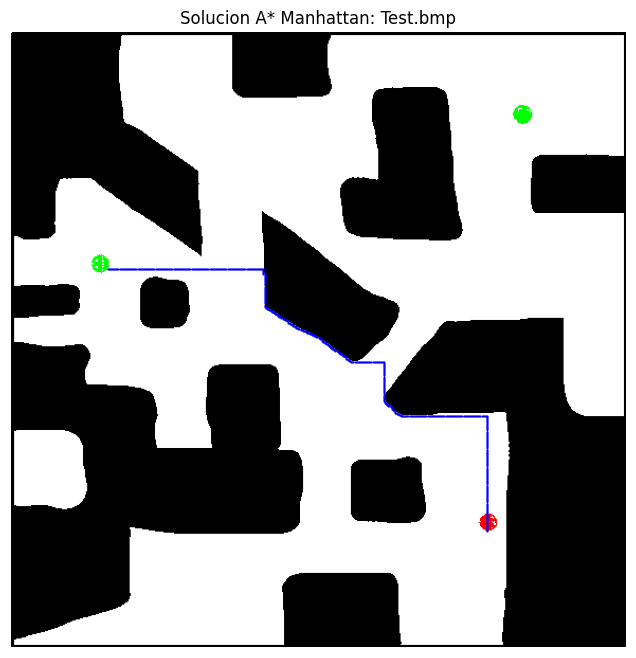


Resolviendo con A* Heuristica Euclidiana...
Camino (A* Euclidiana):
Paso 0: (471, 450)
Paso 1: (470, 450)
Paso 2: (469, 450)
Paso 3: (468, 450)
Paso 4: (467, 450)
Paso 5: (466, 450)
Paso 6: (465, 450)
Paso 7: (464, 450)
Paso 8: (463, 450)
Paso 9: (462, 450)
Paso 10: (461, 450)
Paso 11: (460, 450)
Paso 12: (459, 450)
Paso 13: (458, 450)
Paso 14: (457, 450)
Paso 15: (456, 450)
Paso 16: (455, 450)
Paso 17: (454, 450)
Paso 18: (453, 450)
Paso 19: (452, 450)
Paso 20: (451, 450)
Paso 21: (450, 450)
Paso 22: (449, 450)
Paso 23: (448, 450)
Paso 24: (447, 450)
Paso 25: (446, 450)
Paso 26: (445, 450)
Paso 27: (444, 450)
Paso 28: (443, 450)
Paso 29: (442, 450)
Paso 30: (441, 450)
Paso 31: (440, 450)
Paso 32: (439, 450)
Paso 33: (438, 450)
Paso 34: (437, 450)
Paso 35: (436, 450)
Paso 36: (435, 450)
Paso 37: (434, 450)
Paso 38: (433, 450)
Paso 39: (432, 450)
Paso 40: (431, 450)
Paso 41: (430, 450)
Paso 42: (429, 450)
Paso 43: (428, 450)
Paso 44: (427, 450)
Paso 45: (426, 450)
Paso 46: (425, 450)
P

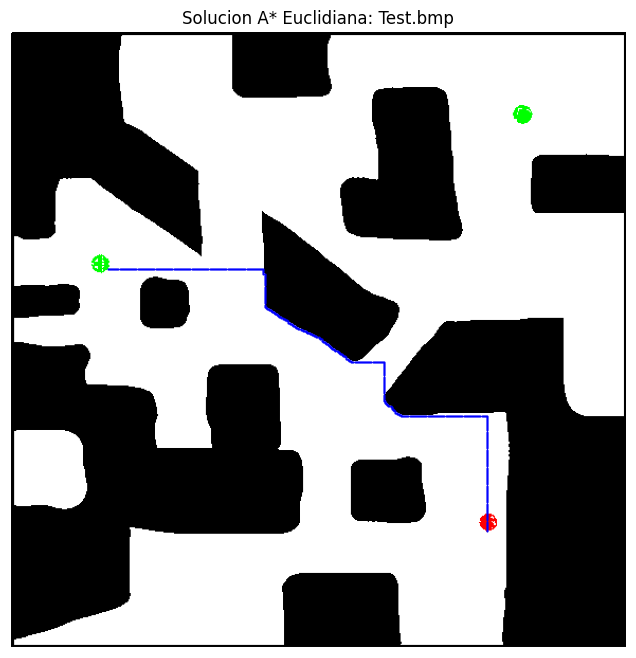


--------------------------------------------------
Procesando imagen: Test2.bmp
Punto de inicio: (434, 432)
Puntos meta: [(57, 227), (57, 228), (57, 229), (57, 230), (57, 231), (57, 232), (57, 233), (57, 234), (58, 225), (58, 226), (58, 227), (58, 228), (58, 229), (58, 230), (58, 231), (58, 232), (58, 233), (58, 234), (58, 235), (58, 236), (58, 237), (59, 223), (59, 224), (59, 225), (59, 226), (59, 227), (59, 228), (59, 229), (59, 230), (59, 231), (59, 232), (59, 233), (59, 234), (59, 235), (59, 236), (59, 237), (59, 238), (60, 221), (60, 222), (60, 223), (60, 224), (60, 225), (60, 226), (60, 227), (60, 228), (60, 229), (60, 230), (60, 231), (60, 232), (60, 233), (60, 234), (60, 235), (60, 236), (60, 237), (60, 238), (60, 239), (60, 240), (61, 220), (61, 221), (61, 222), (61, 223), (61, 224), (61, 225), (61, 226), (61, 227), (61, 228), (61, 229), (61, 230), (61, 231), (61, 232), (61, 233), (61, 234), (61, 235), (61, 236), (61, 237), (61, 238), (61, 239), (61, 240), (61, 241), (62, 219

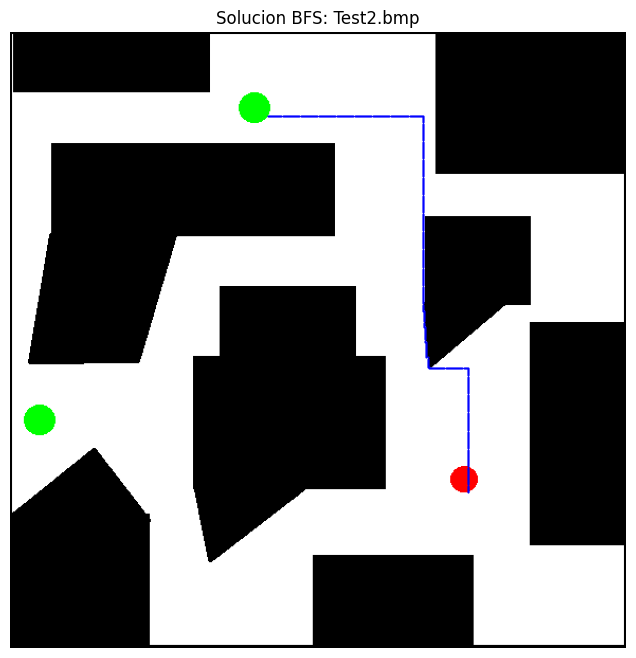


Resolviendo con Depth First Search DFS...
Camino (DFS):
Paso 0: (434, 432)
Paso 1: (434, 433)
Paso 2: (434, 434)
Paso 3: (434, 435)
Paso 4: (434, 436)
Paso 5: (434, 437)
Paso 6: (434, 438)
Paso 7: (434, 439)
Paso 8: (434, 440)
Paso 9: (434, 441)
Paso 10: (434, 442)
Paso 11: (434, 443)
Paso 12: (434, 444)
Paso 13: (434, 445)
Paso 14: (434, 446)
Paso 15: (434, 447)
Paso 16: (434, 448)
Paso 17: (434, 449)
Paso 18: (434, 450)
Paso 19: (434, 451)
Paso 20: (434, 452)
Paso 21: (434, 453)
Paso 22: (434, 454)
Paso 23: (434, 455)
Paso 24: (434, 456)
Paso 25: (434, 457)
Paso 26: (434, 458)
Paso 27: (434, 459)
Paso 28: (434, 460)
Paso 29: (434, 461)
Paso 30: (434, 462)
Paso 31: (434, 463)
Paso 32: (434, 464)
Paso 33: (434, 465)
Paso 34: (434, 466)
Paso 35: (434, 467)
Paso 36: (434, 468)
Paso 37: (434, 469)
Paso 38: (434, 470)
Paso 39: (434, 471)
Paso 40: (434, 472)
Paso 41: (434, 473)
Paso 42: (434, 474)
Paso 43: (434, 475)
Paso 44: (434, 476)
Paso 45: (434, 477)
Paso 46: (434, 478)
Paso 47: (434

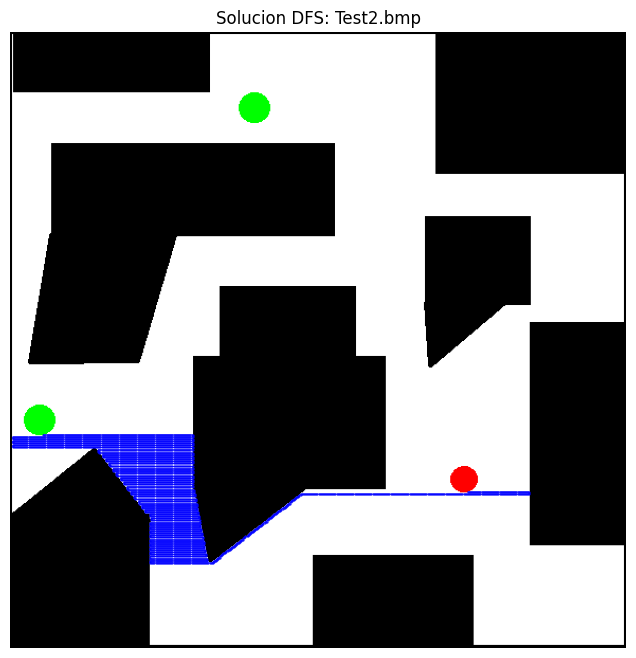


Resolviendo con A* Heuristica Manhattan...
Camino (A* Manhattan):
Paso 0: (434, 432)
Paso 1: (433, 432)
Paso 2: (432, 432)
Paso 3: (431, 432)
Paso 4: (430, 432)
Paso 5: (429, 432)
Paso 6: (428, 432)
Paso 7: (427, 432)
Paso 8: (426, 432)
Paso 9: (425, 432)
Paso 10: (424, 432)
Paso 11: (423, 432)
Paso 12: (422, 432)
Paso 13: (421, 432)
Paso 14: (420, 432)
Paso 15: (419, 432)
Paso 16: (418, 432)
Paso 17: (417, 432)
Paso 18: (416, 432)
Paso 19: (415, 432)
Paso 20: (414, 432)
Paso 21: (413, 432)
Paso 22: (412, 432)
Paso 23: (411, 432)
Paso 24: (410, 432)
Paso 25: (409, 432)
Paso 26: (408, 432)
Paso 27: (407, 432)
Paso 28: (406, 432)
Paso 29: (405, 432)
Paso 30: (404, 432)
Paso 31: (403, 432)
Paso 32: (402, 432)
Paso 33: (401, 432)
Paso 34: (400, 432)
Paso 35: (399, 432)
Paso 36: (398, 432)
Paso 37: (397, 432)
Paso 38: (396, 432)
Paso 39: (395, 432)
Paso 40: (394, 432)
Paso 41: (393, 432)
Paso 42: (392, 432)
Paso 43: (391, 432)
Paso 44: (390, 432)
Paso 45: (389, 432)
Paso 46: (388, 432)
Pas

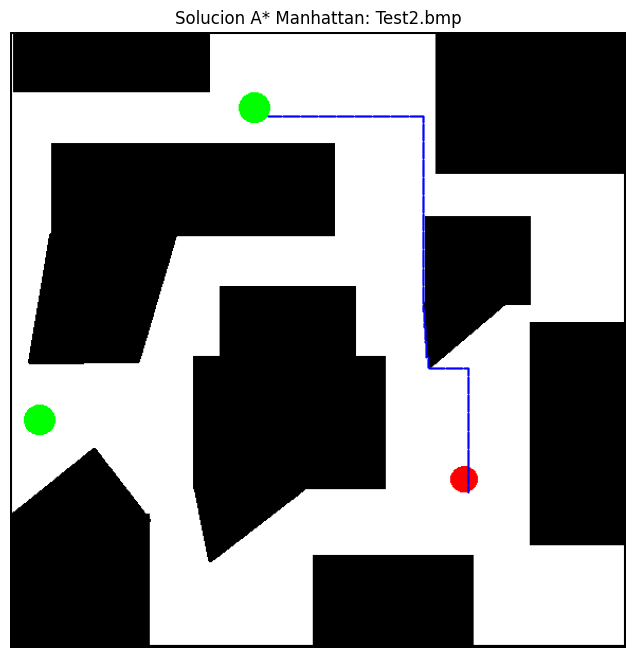


Resolviendo con A* Heuristica Euclidiana...
Camino (A* Euclidiana):
Paso 0: (434, 432)
Paso 1: (433, 432)
Paso 2: (432, 432)
Paso 3: (431, 432)
Paso 4: (430, 432)
Paso 5: (429, 432)
Paso 6: (428, 432)
Paso 7: (427, 432)
Paso 8: (426, 432)
Paso 9: (425, 432)
Paso 10: (424, 432)
Paso 11: (423, 432)
Paso 12: (422, 432)
Paso 13: (421, 432)
Paso 14: (420, 432)
Paso 15: (419, 432)
Paso 16: (418, 432)
Paso 17: (417, 432)
Paso 18: (416, 432)
Paso 19: (415, 432)
Paso 20: (414, 432)
Paso 21: (413, 432)
Paso 22: (412, 432)
Paso 23: (411, 432)
Paso 24: (410, 432)
Paso 25: (409, 432)
Paso 26: (408, 432)
Paso 27: (407, 432)
Paso 28: (406, 432)
Paso 29: (405, 432)
Paso 30: (404, 432)
Paso 31: (403, 432)
Paso 32: (402, 432)
Paso 33: (401, 432)
Paso 34: (400, 432)
Paso 35: (399, 432)
Paso 36: (398, 432)
Paso 37: (397, 432)
Paso 38: (396, 432)
Paso 39: (395, 432)
Paso 40: (394, 432)
Paso 41: (393, 432)
Paso 42: (392, 432)
Paso 43: (391, 432)
Paso 44: (390, 432)
Paso 45: (389, 432)
Paso 46: (388, 432)
P

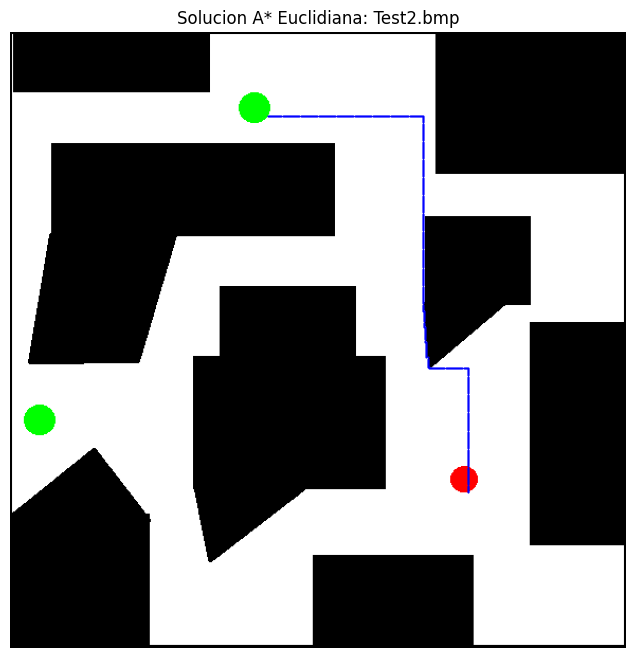


--------------------------------------------------
Procesando imagen: turing.bmp
Punto de inicio: (444, 145)
Puntos meta: [(247, 615), (247, 616), (247, 617), (247, 618), (247, 619), (248, 613), (248, 614), (248, 615), (248, 616), (248, 617), (248, 618), (248, 619), (248, 620), (248, 621), (249, 612), (249, 613), (249, 614), (249, 615), (249, 616), (249, 617), (249, 618), (249, 619), (249, 620), (249, 621), (249, 622), (250, 611), (250, 612), (250, 613), (250, 614), (250, 615), (250, 616), (250, 617), (250, 618), (250, 619), (250, 620), (250, 621), (250, 622), (250, 623), (251, 610), (251, 611), (251, 612), (251, 613), (251, 614), (251, 615), (251, 616), (251, 617), (251, 618), (251, 619), (251, 620), (251, 621), (251, 622), (251, 623), (251, 624), (252, 610), (252, 611), (252, 612), (252, 613), (252, 614), (252, 615), (252, 616), (252, 617), (252, 618), (252, 619), (252, 620), (252, 621), (252, 622), (252, 623), (252, 624), (253, 609), (253, 610), (253, 611), (253, 612), (253, 613), 

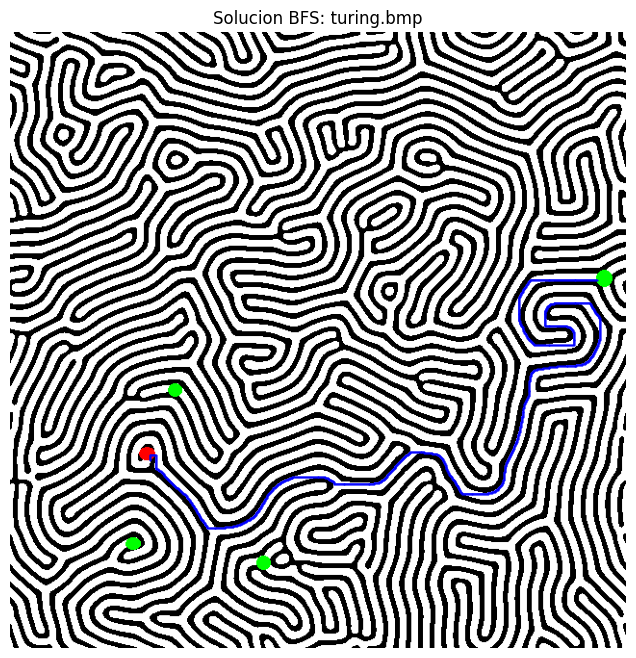


Resolviendo con Depth First Search DFS...
Camino (DFS):
Paso 0: (444, 145)
Paso 1: (444, 144)
Paso 2: (444, 143)
Paso 3: (444, 142)
Paso 4: (444, 141)
Paso 5: (444, 140)
Paso 6: (444, 139)
Paso 7: (444, 138)
Paso 8: (445, 138)
Paso 9: (445, 137)
Paso 10: (446, 137)
Paso 11: (446, 136)
Paso 12: (446, 135)
Paso 13: (446, 134)
Paso 14: (446, 133)
Paso 15: (446, 132)
Paso 16: (446, 131)
Paso 17: (446, 130)
Paso 18: (446, 129)
Paso 19: (446, 128)
Paso 20: (446, 127)
Paso 21: (446, 126)
Paso 22: (445, 126)
Paso 23: (444, 126)
Paso 24: (444, 127)
Paso 25: (444, 128)
Paso 26: (444, 129)
Paso 27: (444, 130)
Paso 28: (444, 131)
Paso 29: (444, 132)
Paso 30: (443, 132)
Paso 31: (442, 132)
Paso 32: (442, 131)
Paso 33: (442, 130)
Paso 34: (442, 129)
Paso 35: (442, 128)
Paso 36: (442, 127)
Paso 37: (442, 126)
Paso 38: (441, 126)
Paso 39: (440, 126)
Paso 40: (440, 127)
Paso 41: (440, 128)
Paso 42: (440, 129)
Paso 43: (440, 130)
Paso 44: (440, 131)
Paso 45: (440, 132)
Paso 46: (439, 132)
Paso 47: (438

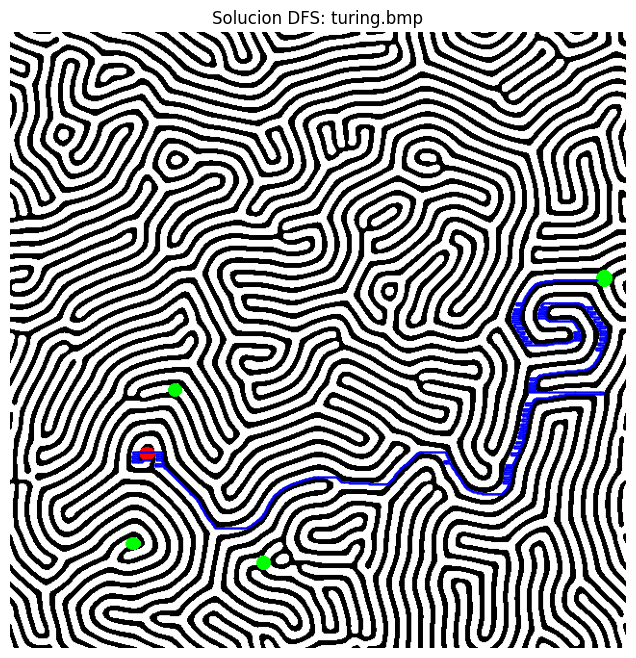


Resolviendo con A* Heuristica Manhattan...
Camino (A* Manhattan):
Paso 0: (444, 145)
Paso 1: (443, 145)
Paso 2: (442, 145)
Paso 3: (441, 145)
Paso 4: (440, 145)
Paso 5: (439, 145)
Paso 6: (439, 146)
Paso 7: (439, 147)
Paso 8: (439, 148)
Paso 9: (439, 149)
Paso 10: (439, 150)
Paso 11: (439, 151)
Paso 12: (439, 152)
Paso 13: (439, 153)
Paso 14: (439, 154)
Paso 15: (439, 155)
Paso 16: (439, 156)
Paso 17: (439, 157)
Paso 18: (440, 157)
Paso 19: (441, 157)
Paso 20: (442, 157)
Paso 21: (443, 157)
Paso 22: (444, 157)
Paso 23: (445, 157)
Paso 24: (446, 157)
Paso 25: (446, 158)
Paso 26: (447, 158)
Paso 27: (448, 158)
Paso 28: (449, 158)
Paso 29: (450, 158)
Paso 30: (450, 159)
Paso 31: (451, 159)
Paso 32: (451, 160)
Paso 33: (452, 160)
Paso 34: (452, 161)
Paso 35: (453, 161)
Paso 36: (453, 162)
Paso 37: (454, 162)
Paso 38: (454, 163)
Paso 39: (455, 163)
Paso 40: (455, 164)
Paso 41: (456, 164)
Paso 42: (456, 165)
Paso 43: (457, 165)
Paso 44: (457, 166)
Paso 45: (458, 166)
Paso 46: (458, 167)
Pas

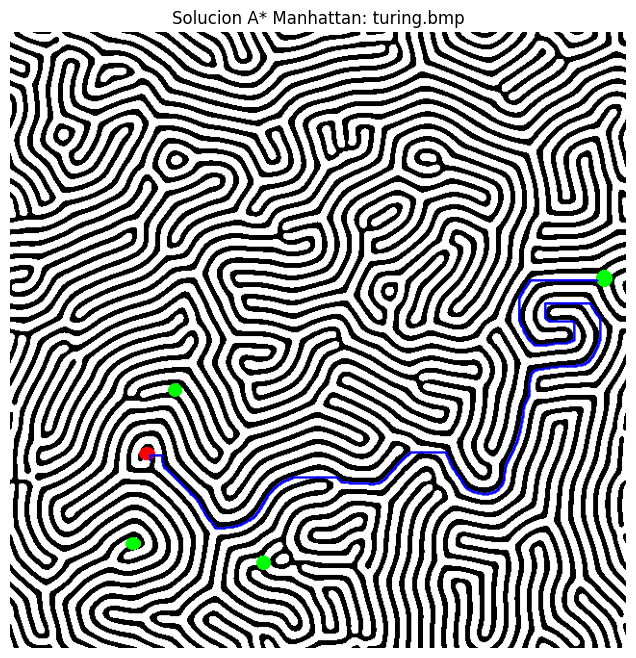


Resolviendo con A* Heuristica Euclidiana...
Camino (A* Euclidiana):
Paso 0: (444, 145)
Paso 1: (443, 145)
Paso 2: (442, 145)
Paso 3: (441, 145)
Paso 4: (440, 145)
Paso 5: (439, 145)
Paso 6: (439, 146)
Paso 7: (439, 147)
Paso 8: (439, 148)
Paso 9: (439, 149)
Paso 10: (439, 150)
Paso 11: (439, 151)
Paso 12: (439, 152)
Paso 13: (439, 153)
Paso 14: (439, 154)
Paso 15: (439, 155)
Paso 16: (439, 156)
Paso 17: (439, 157)
Paso 18: (440, 157)
Paso 19: (441, 157)
Paso 20: (442, 157)
Paso 21: (443, 157)
Paso 22: (444, 157)
Paso 23: (445, 157)
Paso 24: (446, 157)
Paso 25: (446, 158)
Paso 26: (447, 158)
Paso 27: (448, 158)
Paso 28: (449, 158)
Paso 29: (450, 158)
Paso 30: (450, 159)
Paso 31: (451, 159)
Paso 32: (451, 160)
Paso 33: (452, 160)
Paso 34: (452, 161)
Paso 35: (453, 161)
Paso 36: (453, 162)
Paso 37: (454, 162)
Paso 38: (454, 163)
Paso 39: (455, 163)
Paso 40: (455, 164)
Paso 41: (456, 164)
Paso 42: (456, 165)
Paso 43: (457, 165)
Paso 44: (457, 166)
Paso 45: (458, 166)
Paso 46: (458, 167)
P

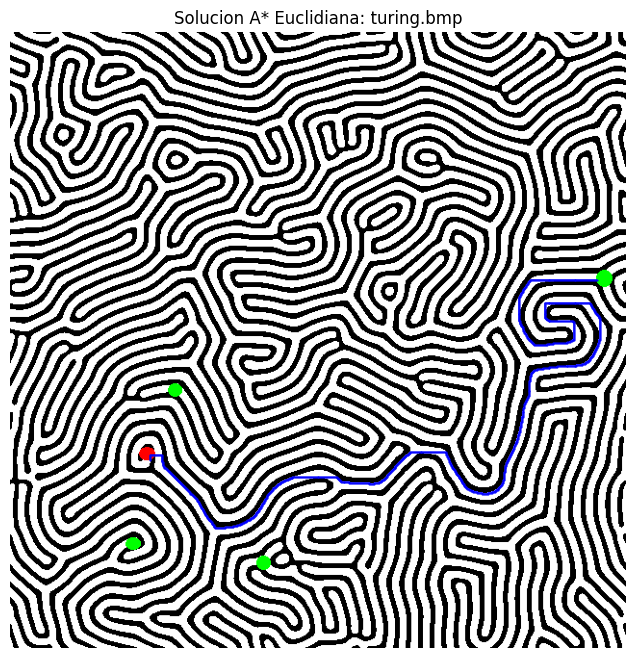

In [64]:
# Lista de nombres de imagen a procesar
nombresArchivos = ["Test.bmp", "Test2.bmp", "turing.bmp"]

# Se itera sobre cada imagen
for nombreArchivo in nombresArchivos:
    print("\n--------------------------------------------------")
    print(f"Procesando imagen: {nombreArchivo}")
    try:
        # Task 1.1: Cargar y discretizar la imagen 
        matriz, inicio, metas = discretizarImagen(nombreArchivo)
        print("Punto de inicio:", inicio)
        print("Puntos meta:", metas)
        
        # Task 1.2: Crear la instancia del problema del laberinto
        problema = ProblemaLaberinto(matriz, inicio, metas)
        
        # Task 1.3 y Task 1.4: Resolver el laberinto con cada algoritmo 
        
        # BFS
        print("\nResolviendo con Breadth First Search BFS...")
        caminoBFS = busquedaAnchura(problema)
        if caminoBFS is not None:
            print("Camino (BFS):")
            for idx, estado in enumerate(caminoBFS):
                print(f"Paso {idx}: {estado}")
        else:
            print("No se encontro solucion usando BFS")
        graficarSolucionLaberinto(matriz, caminoBFS, titulo=f"Solucion BFS: {nombreArchivo}")
        
        # DFS
        print("\nResolviendo con Depth First Search DFS...")
        caminoDFS = busquedaProfundidad(problema)
        if caminoDFS is not None:
            print("Camino (DFS):")
            for idx, estado in enumerate(caminoDFS):
                print(f"Paso {idx}: {estado}")
        else:
            print("No se encontro solucion usando DFS")
        graficarSolucionLaberinto(matriz, caminoDFS, titulo=f"Solucion DFS: {nombreArchivo}")
        
        # A* con Heuristica Manhattan
        print("\nResolviendo con A* Heuristica Manhattan...")
        caminoAEstrellaManhattan = busquedaAEstrella(problema, heuristicaManhattan)
        if caminoAEstrellaManhattan is not None:
            print("Camino (A* Manhattan):")
            for idx, estado in enumerate(caminoAEstrellaManhattan):
                print(f"Paso {idx}: {estado}")
        else:
            print("No se encontro solucion usando A* Manhattan")
        graficarSolucionLaberinto(matriz, caminoAEstrellaManhattan, titulo=f"Solucion A* Manhattan: {nombreArchivo}")
        
        # A* con Heuristica Euclidiana
        print("\nResolviendo con A* Heuristica Euclidiana...")
        caminoAEstrellaEuclidiana = busquedaAEstrella(problema, heuristicaEuclidiana)
        if caminoAEstrellaEuclidiana is not None:
            print("Camino (A* Euclidiana):")
            for idx, estado in enumerate(caminoAEstrellaEuclidiana):
                print(f"Paso {idx}: {estado}")
        else:
            print("No se encontro solucion usando A* Euclidiana")
        graficarSolucionLaberinto(matriz, caminoAEstrellaEuclidiana, titulo=f"Solucion A* Euclidiana: {nombreArchivo}")
        
    except Exception as e:
        print(f"Error procesando la imagen {nombreArchivo}: {e}")

## Conclusión: 
### Los algoritmos más eficientes en la resolución del laberinto son BFS y A* con ambas heurísticas, ya que garantizan la búsqueda del camino más corto. Por otro lado, DFS no siempre encuentra la ruta corta, lo que se refleja en las imágenes del laberinto y los trazos generados en cada solución.







